In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import gym
import torch
import numpy as np
from loguru import logger
from torch.optim import Adam
import matplotlib.pyplot as plt
from IPython.display import Image

from src.utils import (
    device,
    set_seed,
    eval_policy,
    demo_policy,
    plot_returns,
    save_frames_as_gif
)

plt.ion()

In [33]:
SEED: int = 42
ENVIRONMENT_NAME: str='LunarLander-v2'

# torch related defaults
DEVICE = device()
torch.set_default_dtype(torch.float32)

2024-10-18 14:59:43.153 | INFO     | src.utils:device:51 - Using cpu device.


In [4]:
# Use random seeds for reproducibility
set_seed(SEED)

# instantiate the environment
environment = gym.make(ENVIRONMENT_NAME)

# get the state and action dimensions
num_actions = environment.action_space.n
state_dimension = environment.observation_space.shape[0]

2024-10-18 13:21:47.996 | INFO     | src.utils:set_seed:37 - Random seed set as 42.


***

## 1. REINFORCE

In [68]:
from src.networks import Policy
from src.reinforce import train_one_epoch as reinforce_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 800
HIDDEN_DIMENSION: int = 24
LEARNING_RATE: float = 0.03

#############################################################################################

# Instantiate the policy network
policy = Policy(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy
optimizer = Adam(policy.parameters(), LEARNING_RATE)

# Loop for each epoch
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    reinforce_epoch(environment, policy, optimizer)
    
    episode_return_mean, episode_return_std = eval_policy(policy, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='reinforce', dynamic=True
        )

<Figure size 640x480 with 0 Axes>

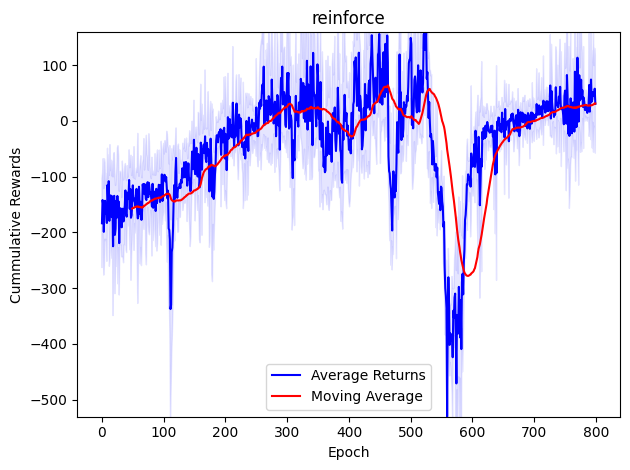

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [69]:
plot_returns(
    mean_returns, std_returns, method_name='reinforce'
)

MovieWriter imagemagick unavailable; using Pillow instead.


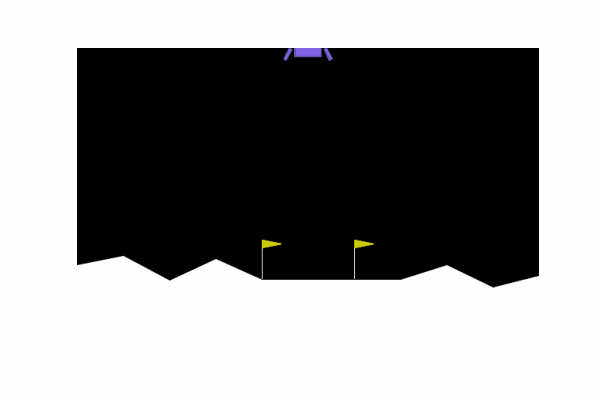

In [70]:
frames = demo_policy(
    policy, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='reinforce')
Image(open(gif_path,'rb').read())

***

## 2. Simple Q-iteration (no experience replay + target network)

In [ ]:
from src.networks import ValueFunctionQ
from src.q_iter import train_one_epoch as q_iter_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 10
HIDDEN_DIMENSION: int = 4
LEARNING_RATE: float = 1e-1

#############################################################################################

# Instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    q_iter_epoch(env=environment, Q=Q, optimizer=optimizer)
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    from src.q_iter import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='dqn', dynamic=True
        )

In [ ]:
plot_returns(
    mean_returns, std_returns, method_name='q_iteration'
)

In [ ]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='q_iteration')
Image(open(gif_path,'rb').read())

***

## Experience Replay Buffer/Memory

In [52]:
from src.buffer import ReplayBuffer
################################## Hyper-parameters Tuning ##################################

BATCH_SIZE: int = 4096
#############################################################################################

# instantiate the memory replay buffer
memory = ReplayBuffer(
    capacity=10_000, batch_size=BATCH_SIZE
)

***

## 3. DQN (Deep Q-learning + experience replay + target network)

In [ ]:
from src.networks import ValueFunctionQ
from src.dqn import train_one_epoch as dqn_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 10
HIDDEN_DIMENSION: int = 4
LEARNING_RATE: float = 1e-1

#############################################################################################

# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy
optimizer = Adam(Q.parameters(), LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):
    
    # copy target network params
    target_Q.load_state_dict(Q.state_dict())

    dqn_epoch(
        env=environment, Q=Q, target_Q=target_Q,
        memory=memory, optimizer=optimizer
    )
    
    episode_return_mean, episode_return_std = eval_policy(Q, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)

    from src.dqn import eps
    
    logger.info(f'Epoch: {epoch:3d}, \t return: {episode_return_mean:.2f}, \t eps: {eps:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='dqn', dynamic=True
        )

In [ ]:
plot_returns(
    mean_returns, std_returns, method_name='dqn'
)

In [ ]:
frames = demo_policy(
    Q, ENVIRONMENT_NAME
)
gif_path = save_frames_as_gif(frames, method_name='dqn')
Image(open(gif_path,'rb').read())

***

## 4. Actor-Critic

In [67]:
from src.networks import Policy
from src.networks import ValueFunctionQ
from src.ac import train_one_epoch as ac_epoch

################################## Hyper-parameters Tuning ##################################

EPOCHS: int = 300
HIDDEN_DIMENSION: int = 24
LEARNING_RATE: float = 0.03

#############################################################################################

# instantiate the state-action value function, Q
Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the target network
target_Q = ValueFunctionQ(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)
# initialize the policy network
policy = Policy(
    state_dimension, num_actions, hidden_dimension=HIDDEN_DIMENSION
).to(DEVICE)

# Learn the policy and Q
optimizer_Q = Adam(Q.parameters(), lr=LEARNING_RATE)
optimizer_pi = Adam(policy.parameters(), lr=LEARNING_RATE)

memory.clear()
mean_returns, std_returns = [], []
for epoch in range(EPOCHS):

    # copy target network params
    target_Q.load_state_dict(Q.state_dict())
    
    ac_epoch(
        env=environment,
        policy=policy, Q=Q, target_Q=target_Q,
        memory=memory, optimizer_Q=optimizer_Q, optimizer_pi=optimizer_pi
    )
    
    episode_return_mean, episode_return_std = eval_policy(policy, ENVIRONMENT_NAME)
    mean_returns.append(episode_return_mean)
    std_returns.append(episode_return_std)
    
    logger.info(f'Epoch: {epoch:3d} \t return: {episode_return_mean:.2f}')

    if epoch:
        plot_returns(
            mean_returns, std_returns, method_name='ac', dynamic=True
        )

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

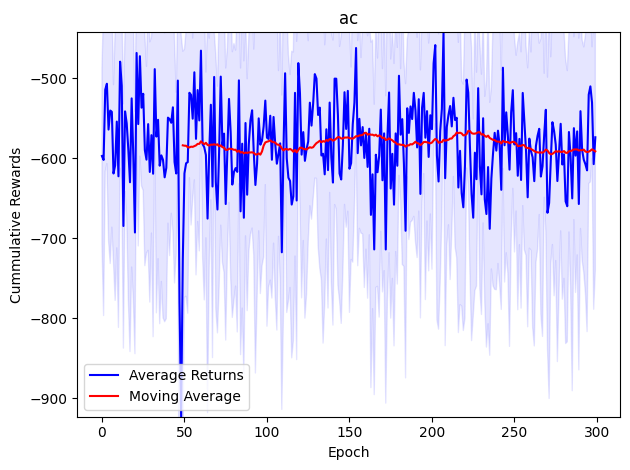

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
plot_returns(
    mean_returns, std_returns, method_name='ac'
)

MovieWriter imagemagick unavailable; using Pillow instead.


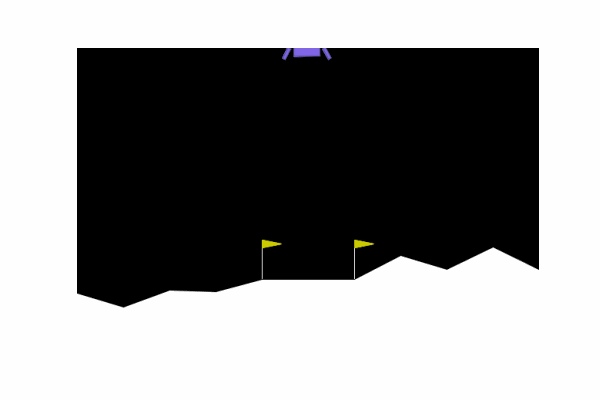

In [13]:
frames = demo_policy(
    policy, ENVIRONMENT_NAME,
)
gif_path = save_frames_as_gif(frames, method_name='ac')
Image(open(gif_path,'rb').read())

***